# Amazon Fine Food Reviews Analysis

## [1]  Reading Data

### [1.1] Loading the data

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 2000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (2000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

## [2] Exploratory Data Analysis

### [2.1] Data Cleaning: Deduplication

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(1998, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.9

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(1998, 10)


1    1691
0     307
Name: Score, dtype: int64

# [3] Preprocessing

### [3.1]. Preprocessing Review Tex

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_1900 = final['Text'].values[1900]
print(sent_1900)
print("="*50)

I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.
These smell so good and are cute and a great size, with a bend in the middle to help roll, and holds together really well with tasty glue. Definitely recommend. Smell like strawberry bubble gum, doesn't really affect flavor too much, but better than plain ones and very sweet. Box says "printed with soy ink" so it's clean and I don't have to worry about ridiculous chemicals for the graphics.
I really like this

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I just received my shipment and could hardly wait to try this product. We love "slickers" which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.
These smell so good and are cute and a great size, with a bend in the middle to help roll, and holds together really well with tasty glue. Definitely recommend. Smell like strawberry bubble gum, doesn't really affect flavor too much, but better than plain ones and very sweet. Box says "printed with soy ink" so it's clean and I don't have to worry about ridiculous chemicals for the graphics.
These tablets definitely mad

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These smell so good and are cute and a great size, with a bend in the middle to help roll, and holds together really well with tasty glue. Definitely recommend. Smell like strawberry bubble gum, does not really affect flavor too much, but better than plain ones and very sweet. Box says "printed with soy ink" so it is clean and I do not have to worry about ridiculous chemicals for the graphics.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These smell so good and are cute and a great size with a bend in the middle to help roll and holds together really well with tasty glue Definitely recommend Smell like strawberry bubble gum does not really affect flavor too much but better than plain ones and very sweet Box says printed with soy ink so it is clean and I do not have to worry about ridiculous chemicals for the graphics 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:01<00:00, 1161.76it/s]


In [0]:
preprocessed_reviews[1500]

'smell good cute great size bend middle help roll holds together really well tasty glue definitely recommend smell like strawberry bubble gum not really affect flavor much better plain ones sweet box says printed soy ink clean not worry ridiculous chemicals graphics'

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aahhhs', 'abates', 'abby', 'abdominal', 'abiding', 'ability', 'able', 'aboulutely', 'absence', 'absent']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1998, 7976)
the number of unique words  7976


## [4.2] Bi-Grams and n-Grams

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1998, 1370)
the number of unique words including both unigrams and bigrams  1370


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able find', 'absolute', 'absolutely', 'absolutely love', 'acid', 'across', 'actual', 'actually', 'add']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1998, 1370)
the number of unique words including both unigrams and bigrams  1370


In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('salty', 0.9998770952224731), ('healthy', 0.9997929930686951), ('good', 0.9997850656509399), ('delicious', 0.9997810125350952), ('light', 0.9997751712799072), ('regular', 0.9997709393501282), ('amazing', 0.9997698664665222), ('calorie', 0.9997678995132446), ('without', 0.9997674822807312), ('products', 0.9997662305831909)]
[('everyone', 0.9994199872016907), ('fish', 0.9994010329246521), ('products', 0.9993987083435059), ('say', 0.9993945360183716), ('bad', 0.9993873834609985), ('anything', 0.9993792176246643), ('brands', 0.9993772506713867), ('made', 0.9993714094161987), ('delicious', 0.9993672370910645), ('alternative', 0.9993672370910645)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2117
sample words  ['received', 'shipment', 'could', 'hardly', 'wait', 'try', 'product', 'love', 'call', 'instead', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'shop', 'going', 'lot', 'fun', 'everywhere', 'like', 'really', 'good', 'idea', 'outstanding', 'everybody', 'bought', 'made', 'two', 'cats', 'crazy', 'last', 'thing', 'want', 'cat', 'food', 'hate', 'buying', 'allows', 'make', 'big', 'spiced', 'nuts', 'fact', 'gold', 'little', 'show', 'people', 'amazed']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V 

### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:02<00:00, 707.46it/s]


1998
50


### [4.4.1.2] TFIDF weighted W2V

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:14<00:00, 135.08it/s]


# [5]  K-Means, Agglomerative & DBSCAN Clustering

## [5.1] K-Means Clustering

In [0]:
# Importing k-Means class from sklearn
from sklearn.cluster import KMeans

# Number of clusters to check.
num_clus = [x for x in range(3,11)]
num_clus

[3, 4, 5, 6, 7, 8, 9, 10]

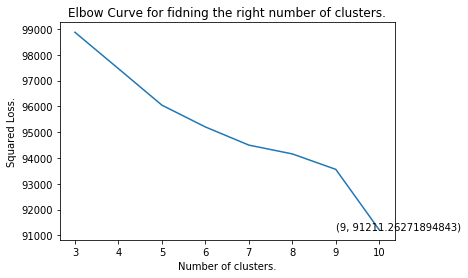

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  91211.26271894843


In [0]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1).fit(final_counts) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [0]:
optimal_k = 9
# Variable that will be used in the conclusion 
bow_means_k = optimal_k

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(final_counts)

In [0]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif kmeans.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif kmeans.labels_[i] == 6:
        cluster7.append(reviews[i])
    elif kmeans.labels_[i] == 7:
        cluster8.append(reviews[i])
    else :
        cluster9.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))
print("\nNo. of reviews in Cluster-9 : ",len(cluster9))

No. of reviews in Cluster-1 :  1327

No. of reviews in Cluster-2 :  53

No. of reviews in Cluster-3 :  22

No. of reviews in Cluster-4 :  1

No. of reviews in Cluster-5 :  2

No. of reviews in Cluster-6 :  49

No. of reviews in Cluster-7 :  376

No. of reviews in Cluster-8 :  167

No. of reviews in Cluster-9 :  1


## [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW

In [0]:
#Reading reviews manually
cluster1[0]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

[nltk_data] Downloading package punkt to C:\Users\BALARAMI
[nltk_data]     REDDY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
cluster1 Word-Cloud


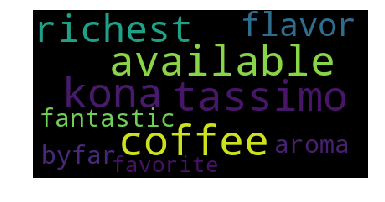

In [0]:
import nltk
nltk.download('punkt')
  

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

for val in cluster1:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()  

In [0]:
cluster2[0]

'used buy product size health food store florida dollars moved ny could not find stores looked online shipping costs still cost dollars use product tea coffee like better real sugar not find bitter even accidently put little much ice tea sometimes forget not real sugar ice tea especially like no additives texture taste used baking simple pound cakes cookies good'

cluster2 Word-Cloud


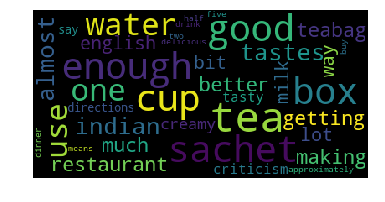

In [0]:
for val in cluster2:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster3[0]

'recently low carb diet find no longer tolerate even natural sugars like agave honey dates raise blood sugar spikes insulin hormone whose message store fat insulin also causes kidneys retain water therefore would bloat high carb diet dilemma love sweets not problem thanks products like stevia natural plant safely used parts world sweetener hundreds years no calories no impact blood sugar although people might bit brain tricked thinking getting sugar stevia used legal usa cosmetic product politics companies made low calorie sweeteners aspartame not want competition yet aspartame gave headaches even sometimes symptoms multiple sclerosis would use stevia times aftertaste bad honest not crazy taste either tried nunaturals product awesome like no stevia tried not delicious also no aftertaste unless put way much common mistake people new comes tablets powdered form bottle handy packets individual servings also comes alcohol free liquid form even vanilla flavor unlike aspartame becomes even t

cluster3 Word-Cloud


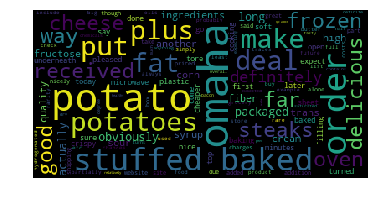

In [0]:
for val in cluster3:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster3
    for words in tokens:
        cluster3_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster3 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster3_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster4[0]

'question followed reply good customer service hey guys trying feed new born much breast milk however not enough meet nutritional needs formula order supplement interested toddler formula appears since meets fda infant formula guidelines safe opinions internet seem feel way however doctor says not used higher amounts calcium phosphorous also concerned using dha ara supplement concerns egg white process proteins egg whites not good infant thoughts thanks answerdear dave thank contacting nature one firstly correct baby organic formulas meet nutritional requirements fda infant formula act no dilution needed babies months age please follow label mixing instructions regarding calcium phosphorous content baby organic formulas calcium essential nutrient needed bone health american academy pediatrics expert panel nutrient levels infant formula provided recommendations amount calcium minimum per calories milligrams maximum milligrams per calories phosphorus another important mineral bone health

cluster4 Word-Cloud


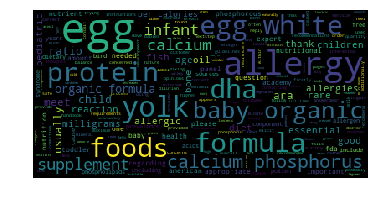

In [0]:
for val in cluster4:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster4
    for words in tokens:
        cluster4_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster4 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster4_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster5[0]

'loved chips chips would buy discovered england back quickly became fan year ago picked bag sale local supermarket finding odd sale much took advantage opening bag found chips not even close kettle chips used uniform whitish yellow color flavor way lovely extra crisp brown chips gone completely disappointed e mailed kettle following happened bought bag chips day different taste tastes cheaper not know else put also noticed chips seemed less cooked not see browner colored chips flavor hoping nothing changed ingredients process used produce product get weird batch buying kettle chips years wondering receive reply thanks letting us know experience kettle brand chips sounds like may received bag not slipped inspections apologize potatoes vary seasonally could account variation color chips still taste great thanks providing us best code bag really helps passing comments staff sending coupons replace purchase kettle brand flavors nut butters believing great experience next purchase case buy 

cluster5 Word-Cloud


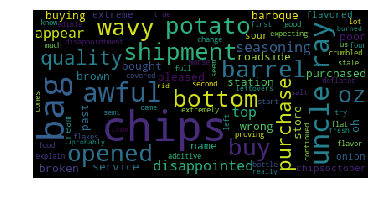

In [0]:
for val in cluster5:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster5
    for words in tokens:
        cluster5_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster5 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster5_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster6[0]

'product high quality rich full flavor delivery unexpectedly fast negative would like see addressed product packed heavy paper sack may commonplace significant improvement would inner liner heavy weight food grade plastic bag sealed time open bag could either zip lock bag twist tie closure not make difference need practical way preserve freshness product keep bugs health spoilage issue oatmeal lot product needs either repackaged consumer small food grade bags containers expensive hard find single senior likes buy staple goods bulk save money provide food security long term storage big issue people like thom missouri'

cluster6 Word-Cloud


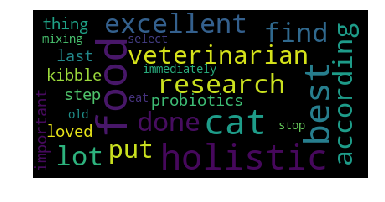

In [0]:
for val in cluster6:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster6
    for words in tokens:
        cluster6_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster6 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster6_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster7[2]

'forget starbucks peets anything else real deal like good vintage wine britt coffee truly gourmet no taste really fussy coffee generally avoid trip costa rica fell love beverage use french press get full favor throw away coffee making contraptions beans deserve best taste buds deserve best no not work britt not get paid say guys britt read send sample two'

cluster7 Word-Cloud


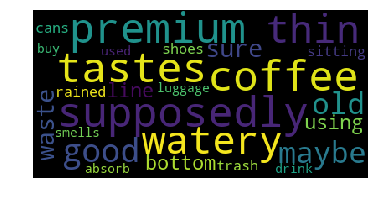

In [0]:
for val in cluster7:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster7
    for words in tokens:
        cluster7_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster7 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster7_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster8[1]

'potato chips delicious not potato chips approximately two years difficult find organic chips amazon lowered price finally chance order definitely ordering family love pure void artificial flavorings true flavor present satisifies need something salty sweet spicy crunchy'

cluster8 Word-Cloud


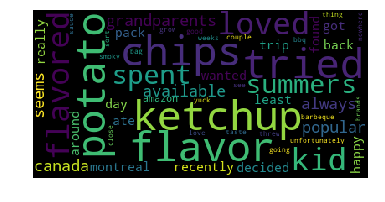

In [0]:
for val in cluster8:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster8
    for words in tokens:
        cluster8_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster8 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster8_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster9[0]

'getting worried read reviews specifically one star reviews always go see faults reviewers find merchandise would prevent buying wow sure seemed hate kettle chips backyard barbecue bags pack bought ounce bags liked lot decided subscribe good measure got orders ounce bags yes love potato chips especially kettle chips backyard barbecue flavour others seemed really hate least hate changed realized talking flavours amazon deep wisdom obviously seen fit put comments concerning flavours kettle brands potato chips together course advantages potato chip lovers like enjoy eating several flavour brand varieties comparisons made easily also potato chip lovers person favourite flavour reviewing sort united nations potato chip lovers different united love potato chips rest world really benefit example tightly knit ever er expanding group think not first realizing thesedifferent flavour reviews together cause little confusion dismay least begin amazon mentioned kettle potato chip review forum happy 

cluster9 Word-Cloud


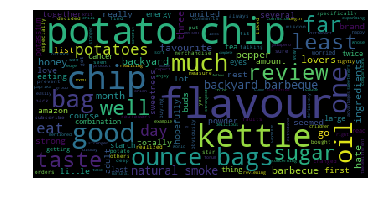

In [0]:
for val in cluster9:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster9
    for words in tokens:
        cluster9_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster9 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster9_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## [5.1.3] Applying K-Means Clustering on TFIDF

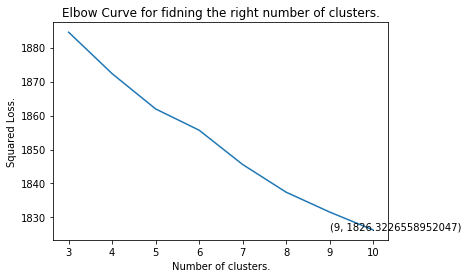

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  1826.3226558952047


In [0]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1).fit(final_tf_idf) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))


In [0]:
optimal_k = 9

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(final_tf_idf)

In [0]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif kmeans.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif kmeans.labels_[i] == 6:
        cluster7.append(reviews[i])
    elif kmeans.labels_[i] == 7:
        cluster8.append(reviews[i])
    else :
        cluster9.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))
print("\nNo. of reviews in Cluster-9 : ",len(cluster9))

No. of reviews in Cluster-1 :  117

No. of reviews in Cluster-2 :  103

No. of reviews in Cluster-3 :  77

No. of reviews in Cluster-4 :  120

No. of reviews in Cluster-5 :  808

No. of reviews in Cluster-6 :  186

No. of reviews in Cluster-7 :  325

No. of reviews in Cluster-8 :  185

No. of reviews in Cluster-9 :  77


## [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF

In [0]:
#Reading reviews manually
cluster1[0]

'nine cats crazy kibbles last thing want cat food cats hate buying'

[nltk_data] Downloading package punkt to C:\Users\BALARAMI
[nltk_data]     REDDY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
cluster1 Word-Cloud


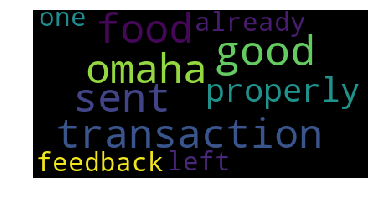

In [0]:
import nltk
nltk.download('punkt')
  

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

for val in cluster1:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster2[0]

'used buy product size health food store florida dollars moved ny could not find stores looked online shipping costs still cost dollars use product tea coffee like better real sugar not find bitter even accidently put little much ice tea sometimes forget not real sugar ice tea especially like no additives texture taste used baking simple pound cakes cookies good'

cluster2 Word-Cloud


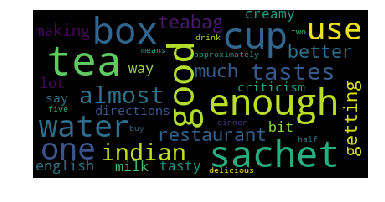

In [0]:
for val in cluster2:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster3[0]

'husband fell love cafe britt coffee costa rica upon return delighted see could order amazon com coffee easy drink not bitter harsh great way start day highly recommended'

cluster3 Word-Cloud


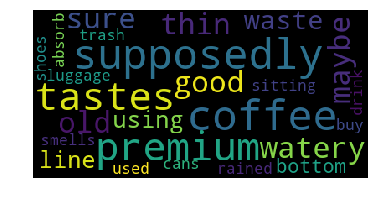

In [0]:
for val in cluster3:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster3
    for words in tokens:
        cluster3_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster3 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster3_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster4[0]

'crackers great snack no cholestoral use sea salt crunchy like eating potato chips better comes different flavors prefer plain found salt content different purchases sometimes salty sometimes hardly salt must problem production line crackers become addicting ok cause rice good us'

cluster4 Word-Cloud


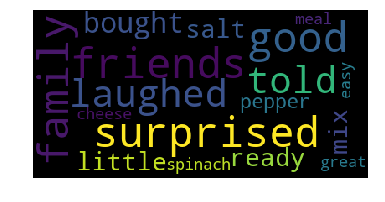

In [0]:
for val in cluster4:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster4
    for words in tokens:
        cluster4_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster4 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster4_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster5[0]

'purchased item cake called gold dust never thought would find im glad sprinkled looked like shining star container small go long way worth buying'

cluster5 Word-Cloud


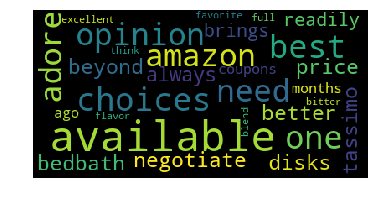

In [0]:
for val in cluster5:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster5
    for words in tokens:
        cluster5_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster5 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster5_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster6[0]

'used pioneer gravy number years easy make tastes great also goes well mashed potatoes meats etc try'

cluster6 Word-Cloud


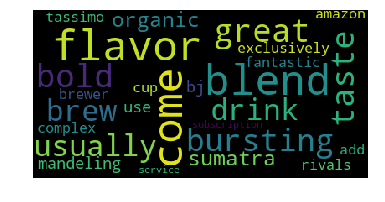

In [0]:
for val in cluster6:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster6
    for words in tokens:
        cluster6_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster6 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster6_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster7[2]

'like chips salsa quacomole better cips market even great order long available thank making accessable shelly kenyon'

cluster7 Word-Cloud


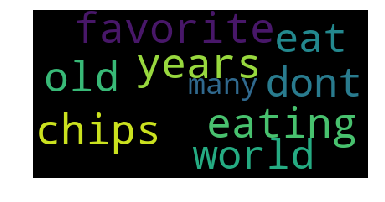

In [0]:
for val in cluster7:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster7
    for words in tokens:
        cluster7_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster7 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster7_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster8[0]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

cluster8 Word-Cloud


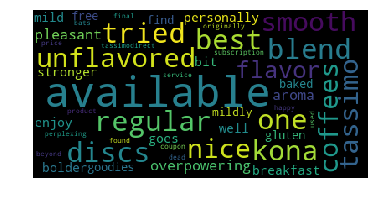

In [0]:
for val in cluster8:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster8
    for words in tokens:
        cluster8_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster8 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster8_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster9[0]

'gravy mix excellent except not use water called use milk instead makes better'

cluster9 Word-Cloud


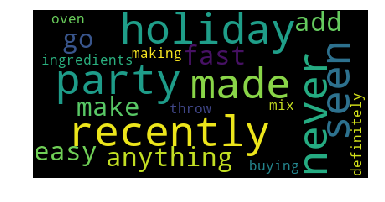

In [0]:
for val in cluster9:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster9
    for words in tokens:
        cluster9_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster9 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster9_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## [5.1.5] Applying K-Means Clustering on AVG W2V

In [0]:
avg_vec_google = np.array(sent_vectors)

In [0]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = final['Score'][mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(1998, 50)
(1998,)


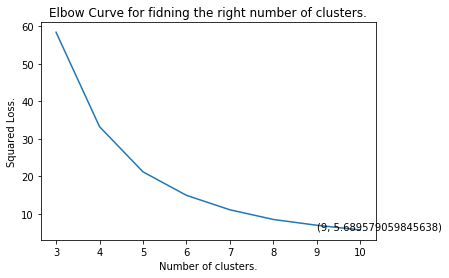

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  5.689579059845638


In [0]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1).fit(avg_vec_google_new) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [0]:
optimal_k = 9


# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(avg_vec_google_new)

In [0]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif kmeans.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif kmeans.labels_[i] == 6:
        cluster7.append(reviews[i])
    elif kmeans.labels_[i] == 7:
        cluster8.append(reviews[i])
    else :
        cluster9.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))
print("\nNo. of reviews in Cluster-9 : ",len(cluster9))

No. of reviews in Cluster-1 :  240

No. of reviews in Cluster-2 :  353

No. of reviews in Cluster-3 :  5

No. of reviews in Cluster-4 :  369

No. of reviews in Cluster-5 :  277

No. of reviews in Cluster-6 :  94

No. of reviews in Cluster-7 :  217

No. of reviews in Cluster-8 :  375

No. of reviews in Cluster-9 :  68


## [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V

In [0]:
#Reading reviews manually
cluster1[0]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

[nltk_data] Downloading package punkt to C:\Users\BALARAMI
[nltk_data]     REDDY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
cluster1 Word-Cloud


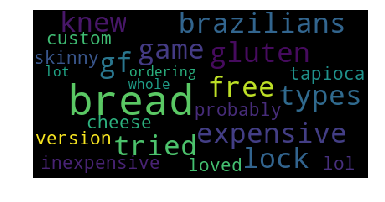

In [0]:
import nltk
nltk.download('punkt')
  

intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

for val in cluster1:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster2[0]

'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs'

cluster2 Word-Cloud


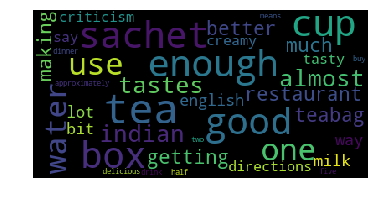

In [0]:
for val in cluster2:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster4[1]

'five minutes one tentacle bitten ball inside cracked half not durable enough dog toy disappointed dog'

cluster4 Word-Cloud


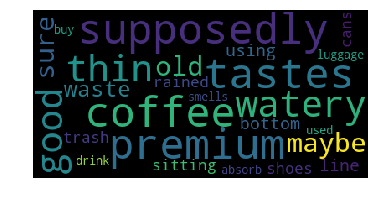

In [0]:
for val in cluster4:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster4
    for words in tokens:
        cluster4_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster4 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster4_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster5[0]

'gravy mix excellent except not use water called use milk instead makes better'

cluster5 Word-Cloud


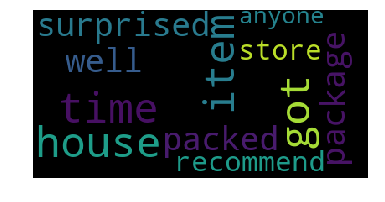

In [0]:
for val in cluster5:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster5
    for words in tokens:
        cluster5_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster5 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster5_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster6[0]

'need cut sugar way go love stevia iced tea great cereal also great stuff'

cluster6 Word-Cloud


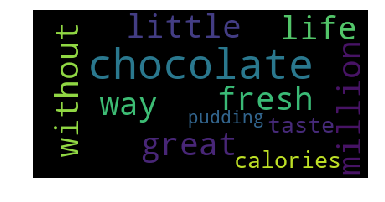

In [0]:
for val in cluster6:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster6
    for words in tokens:
        cluster6_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster6 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster6_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster7[2]

'hated stevia licorice taste tried nustevia since day almost completely eliminated sugar drinks like plant based product not bio engineered no taste need little make anything taste sweet'

cluster7 Word-Cloud


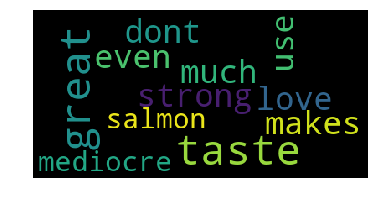

In [0]:
for val in cluster7:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster7
    for words in tokens:
        cluster7_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster7 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster7_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster8[1]

'purchased item cake called gold dust never thought would find im glad sprinkled looked like shining star container small go long way worth buying'

cluster8 Word-Cloud


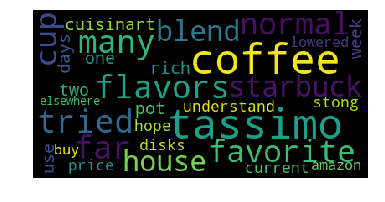

In [0]:
for val in cluster8:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster8
    for words in tokens:
        cluster8_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster8 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster8_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster9[0]

'used super gold luster dust create exquisite chocolate aspen leaves groom cake son wedding using artist paintbrush lightly coat molded leaves luster dust result startlingly beautiful contrast food coloring luster dust brushes easily imparts realistically metallic color sheen containers small product goes long way making extremely economical use'

cluster9 Word-Cloud


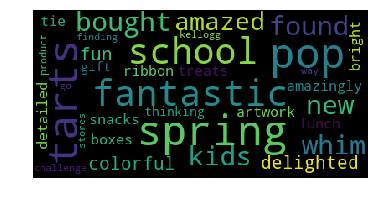

In [0]:
for val in cluster9:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster9
    for words in tokens:
        cluster9_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster9 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster9_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## [5.1.7] Applying K-Means Clustering on TFIDF W2V

In [0]:
tfidf_w2v_vec_google = np.array(tfidf_sent_vectors)

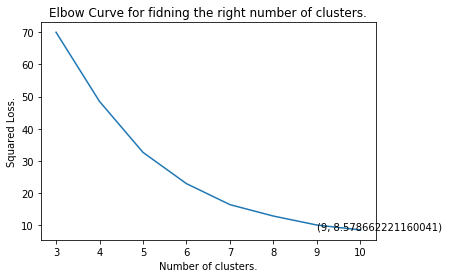

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  8.578662221160041


In [0]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1).fit(tfidf_w2v_vec_google) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [0]:
optimal_k = 9

# Implementing K-Means++ using optimal value of K
kmeans = KMeans(n_clusters=optimal_k, n_jobs=-1).fit(tfidf_w2v_vec_google)

In [0]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(reviews[i])
    elif kmeans.labels_[i] == 5:
        cluster6.append(reviews[i])
    elif kmeans.labels_[i] == 6:
        cluster7.append(reviews[i])
    elif kmeans.labels_[i] == 7:
        cluster8.append(reviews[i])
    else :
        cluster9.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))
print("\nNo. of reviews in Cluster-6 : ",len(cluster6))
print("\nNo. of reviews in Cluster-7 : ",len(cluster7))
print("\nNo. of reviews in Cluster-8 : ",len(cluster8))
print("\nNo. of reviews in Cluster-9 : ",len(cluster9))

No. of reviews in Cluster-1 :  255

No. of reviews in Cluster-2 :  302

No. of reviews in Cluster-3 :  378

No. of reviews in Cluster-4 :  5

No. of reviews in Cluster-5 :  180

No. of reviews in Cluster-6 :  98

No. of reviews in Cluster-7 :  64

No. of reviews in Cluster-8 :  312

No. of reviews in Cluster-9 :  404


## [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V

In [0]:
#Reading reviews manually
cluster1[0]

'love water uplifting feel better drinking arsenic free flouride free chromium free chlorine free mtbe free something reverse osmosis medicinal grade oxygen really works work no longer allowed drink soda classrooms bought penta water hooked like one liter size bottles wish would sell also lucky purchase dorthy lane market buy water'

cluster1 Word-Cloud


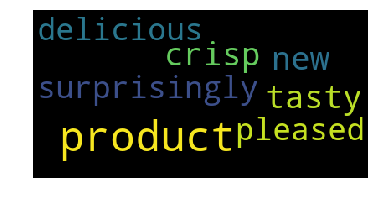

In [0]:
for val in cluster1:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster2[0]

'used product multiple times fact purchased four tubs gold silver luster dust five years ago running use stuff gild sorts things renaissance themed banquets including gilding entire roast duck using vodka painting filigree designs onto clients thought prop food looked beautiful not recommend stuff enough'

cluster2 Word-Cloud


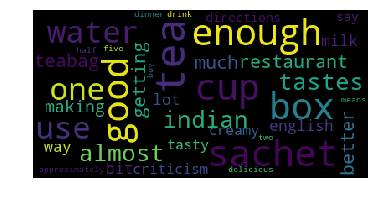

In [0]:
for val in cluster2:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster3[0]

'nine cats crazy kibbles last thing want cat food cats hate buying'

cluster3 Word-Cloud


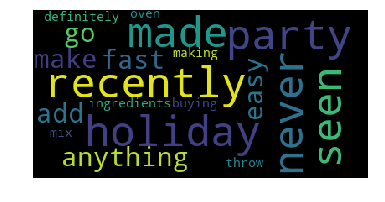

In [0]:
for val in cluster3:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster3
    for words in tokens:
        cluster3_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster3 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster3_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster5[0]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

cluster5 Word-Cloud


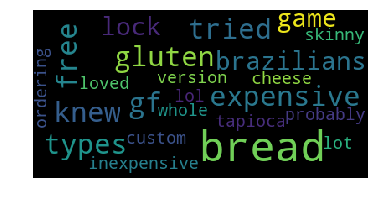

In [0]:
for val in cluster5:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster5
    for words in tokens:
        cluster5_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster5 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster5_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster6[0]

'need cut sugar way go love stevia iced tea great cereal also great stuff'

cluster6 Word-Cloud


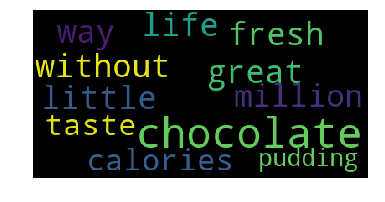

In [0]:
for val in cluster6:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster6
    for words in tokens:
        cluster6_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster6 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster6_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster7[2]

'ordered coffee themed wedding arrived fight friends smelled tasted good literally hide box wedding big hit wedding day none left put tables great tasting product lowest price seen'

cluster7 Word-Cloud


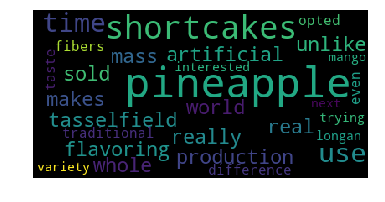

In [0]:
for val in cluster7:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster7
    for words in tokens:
        cluster7_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster7 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster7_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster8[1]

'gravy mix excellent except not use water called use milk instead makes better'

cluster8 Word-Cloud


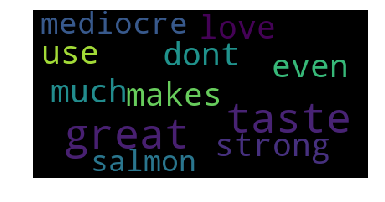

In [0]:
for val in cluster8:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster8
    for words in tokens:
        cluster8_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster8 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster8_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster9[0]

'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs'

cluster9 Word-Cloud


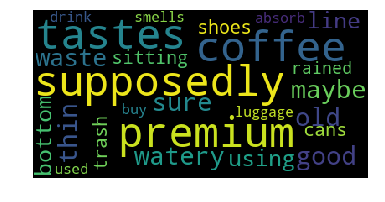

In [0]:
for val in cluster9:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster9
    for words in tokens:
        cluster9_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster9 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster9_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V

In [0]:
avg_vec_google = np.array(sent_vectors)

In [0]:
reviews = preprocessed_reviews

model = AgglomerativeClustering(n_clusters=5).fit(avg_vec_google)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  475

No. of reviews in Cluster-2 :  627

No. of reviews in Cluster-3 :  338

No. of reviews in Cluster-4 :  5

No. of reviews in Cluster-5 :  553


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V

In [0]:
#Reading reviews manually
cluster1[0]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

cluster1 Word-Cloud


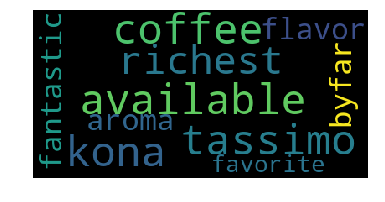

In [0]:
for val in cluster1:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster2[0]

'nine cats crazy kibbles last thing want cat food cats hate buying'

cluster2 Word-Cloud


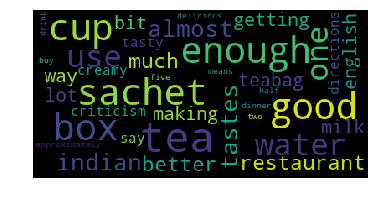

In [0]:
for val in cluster2:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster3[0]

'great tasting coffiee one best ever problem high shipping costs'

cluster3 Word-Cloud


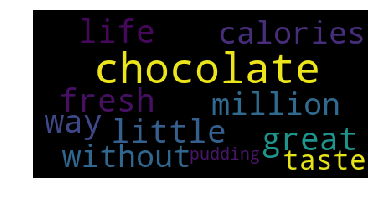

In [0]:
for val in cluster3:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster3
    for words in tokens:
        cluster3_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster3 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster3_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster5[0]

'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs'

cluster5 Word-Cloud


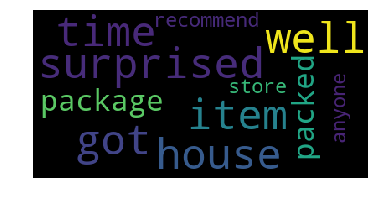

In [0]:
for val in cluster5:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster5
    for words in tokens:
        cluster5_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster5 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster5_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V 

In [0]:
tfidf_w2v_vec_google = np.array(tfidf_sent_vectors)

In [0]:
model = AgglomerativeClustering(n_clusters=5).fit(tfidf_w2v_vec_google)

# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  99

No. of reviews in Cluster-2 :  454

No. of reviews in Cluster-3 :  472

No. of reviews in Cluster-4 :  554

No. of reviews in Cluster-5 :  419


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V 

In [0]:
#Reading reviews manually
cluster1[0]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

cluster1 Word-Cloud


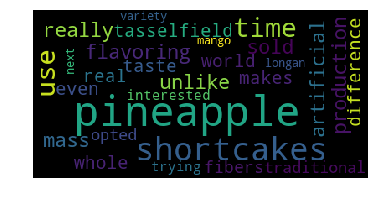

In [0]:
for val in cluster1:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()  

In [0]:
cluster2[0]

'used product multiple times fact purchased four tubs gold silver luster dust five years ago running use stuff gild sorts things renaissance themed banquets including gilding entire roast duck using vodka painting filigree designs onto clients thought prop food looked beautiful not recommend stuff enough'

cluster2 Word-Cloud


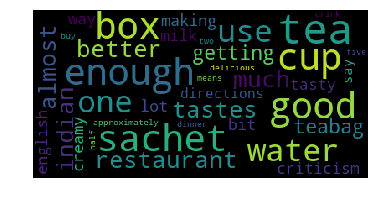

In [0]:
for val in cluster2:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster3[0]

'not know cactus tequila unique combination ingredients flavour hot sauce makes one kind picked bottle trip brought back home us totally blown away realized simply could not find anywhere city bummed magic internet case sauce ecstatic love hot sauce mean really love hot sauce not want sauce tastelessly burns throat grab bottle tequila picante gourmet de inclan realize taste never want use sauce thank personal incredible service'

cluster3 Word-Cloud


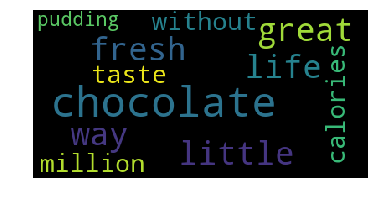

In [0]:
for val in cluster3:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster3
    for words in tokens:
        cluster3_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster3 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster3_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster4[0]

'nine cats crazy kibbles last thing want cat food cats hate buying'

cluster4 Word-Cloud


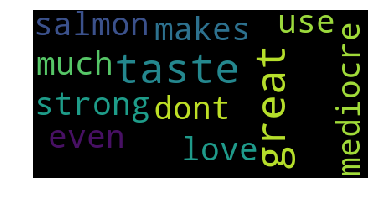

In [0]:
for val in cluster4:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster4
    for words in tokens:
        cluster4_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster4 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster4_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
cluster5[0]

'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs'

cluster5 Word-Cloud


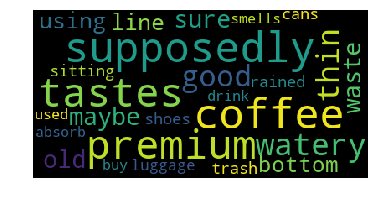

In [0]:
for val in cluster5:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster5
    for words in tokens:
        cluster5_words = words + ' '


from wordcloud import WordCloud
plt.ion()
print ("cluster5 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster5_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V

In [0]:
# function to determinethe distance of nth-nearest neighbour to all points in a multi-dimensional array
def n_neighbour(vectors , n):
    distance = []
    for point in vectors:
        temp = np.sort(np.sum((vectors-point)**2,axis=1),axis=None)
        distance.append(temp[n])
    return np.sqrt(np.array(distance))

In [0]:
# Function definition for implementing DBSCAN
def dbscan(epsilon, samples, Data):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=samples, n_jobs=-1).fit(Data)
    
    # Number of clusters in labels, ignoring noise(-1) if present.
    n_clusters = len(set(db.labels_))
    print("Number of clusters for MinPts = %d and Epsilon = %f is : %d "%(samples,epsilon,n_clusters))
    print("Labels(-1 is for Noise) : ",set(db.labels_))
    print()
    return db

In [0]:
avg_vec_google = np.array(sent_vectors)

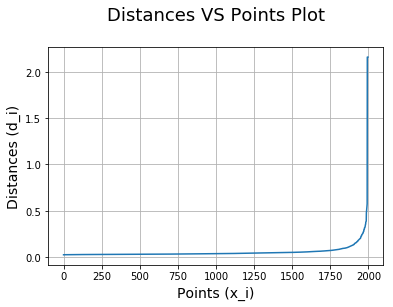

In [0]:
min_points = 2*avg_vec_google.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(avg_vec_google,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(avg_vec_google.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

#### OBSERVATION :- From above we can see that the right value of Epsilon is 0.3 because after that there is sharp rise in the value of distances (d_i's) 

In [0]:
optimal_eps = 0.2
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points,avg_vec_google )

Number of clusters for MinPts = 100 and Epsilon = 0.200000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



In [0]:
reviews = preprocessed_reviews
#model = db(optimal_eps, min_points,avg_vec_google)

cluster1 = []
cluster2 = []
for i in range(db1.labels_.shape[0]):
    if db1.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])

# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  1986

No. of reviews in Cluster-2 :  12


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V 

In [0]:
#Reading reviews manually
cluster1[1]

'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs'

cluster1 Word-Cloud


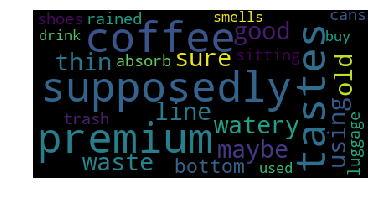

In [0]:
for val in cluster1:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

In [0]:
print(cluster2[6])

terrific english triffle beware though pack containers makes gallon pudding


cluster2 Word-Cloud


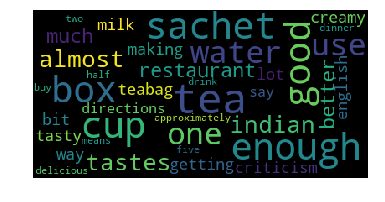

In [0]:
for val in cluster2:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 

### [5.3.3] Applying DBSCAN on TFIDF W2V 

In [0]:
tfidf_w2v_vec_google = np.array(tfidf_sent_vectors)

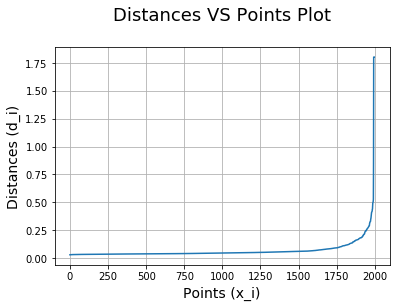

In [0]:
min_points = 2*tfidf_w2v_vec_google.shape[1]

# Computing distances of nth-nearest neighbours
distances = n_neighbour(tfidf_w2v_vec_google,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(tfidf_w2v_vec_google.shape[0])]

# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_distance)
plt.xlabel('Points (x_i)',size=14)
plt.ylabel('Distances (d_i)',size=14)
plt.title('Distances VS Points Plot\n',size=18)
plt.grid()
plt.show()

##### OBSERVATION :- From above we can see that the right value of Epsilon is 0.2 because after that there is sharp rise in the value of distances (d_i's)  

In [0]:
optimal_eps = 0.2
# Clustering with right epsilon
db1 = dbscan(optimal_eps, min_points,avg_vec_google )

Number of clusters for MinPts = 100 and Epsilon = 0.200000 is : 2 
Labels(-1 is for Noise) :  {0, -1}



In [0]:
reviews = preprocessed_reviews
#model = db(optimal_eps, min_points,avg_vec_google)

cluster1 = []
cluster2 = []
for i in range(db1.labels_.shape[0]):
    if db1.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])

# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  1986

No. of reviews in Cluster-2 :  12


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V

In [0]:
#Reading reviews manually
cluster1[0]

'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors'

cluster1 Word-Cloud


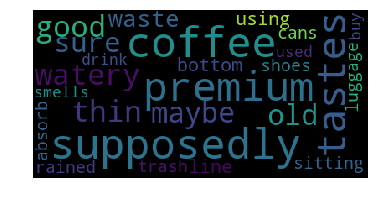

In [0]:
for val in cluster1:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster1
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster1 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster1_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
cluster2[1]

'love sugar also get muscavado sugar great use place regular white sugar recommend'

cluster2 Word-Cloud


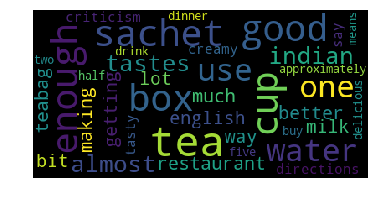

In [0]:
for val in cluster2:
    text = val.lower()
    text = text.translate(trantab)
    tokens = nltk.word_tokenize(text)
    tokens = cluster2
    for words in tokens:
        cluster1_words = words + ' '

from wordcloud import WordCloud
plt.ion()
print ("cluster2 Word-Cloud")
wordcloud = WordCloud(max_font_size=50).generate(cluster2_words)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show() 